


# XGBoost Algorithm



In [95]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import set_printoptions

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

In [2]:
df_ppi_1 = pd.read_csv('data/base_cerevisiae.csv')
df_ppi_2 = pd.read_csv('data/base_elegans.csv')
df_ppi_3 = pd.read_csv('data/base_droso.csv')

In [38]:
df = pd.concat([df_ppi_1, df_ppi_2, df_ppi_3])
df

,Locus,Sequence,Sequence_Length,Sec_Struct_Helix,Sec_Struct_Turn,Sec_Struct_Sheet,Percent_A,Percent_C,Percent_D,Percent_E,...,Percent_V,Percent_W,Percent_Y,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,YPL071C,MSSRFARSNGNPNHIRKRNHSPDPIGIDNYKRKRLIIDLENLSLND...,156,0.288462,0.211538,0.185897,0.044872,0.006410,0.128205,0.044872,...,0.038462,0.032051,0.038462,4932.YPL071C,0.000986,0.000512,3.315435e-06,0.426787,0.266667,0
1,YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,143,0.307692,0.244755,0.237762,0.076923,0.006993,0.083916,0.069930,...,0.083916,0.006993,0.048951,4932.YLL050C,0.053392,0.017135,2.003725e-04,0.497262,0.302355,1
2,YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,719,0.219750,0.326843,0.214186,0.055633,0.002782,0.058414,0.047288,...,0.030598,0.004172,0.018081,4932.YMR172W,0.007557,0.002314,3.144740e-06,0.438952,0.289855,0
3,YOR185C,MSAPAQNNAEVPTFKLVLVGDGGTGKTTFVKRHLTGEFEKKYIATI...,220,0.318182,0.195455,0.236364,0.077273,0.013636,0.063636,0.063636,...,0.081818,0.013636,0.040909,4932.YOR185C,0.046164,0.017683,1.040158e-04,0.491754,0.307905,0
4,YLL032C,MDNFKIYSTVITTAFLQVPHLYTTNRLWKPIEAPFLVEFLQKRISS...,825,0.335758,0.244848,0.225455,0.042424,0.010909,0.042424,0.066667,...,0.043636,0.002424,0.043636,4932.YLL032C,0.021028,0.006141,1.265410e-04,0.473128,0.236713,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11311,7227.FBpp0306211,MARLISGVRNLFHRYPFVTNSAIYGSLYVGAEYSQQFASKRWLATA...,204,0.392157,0.196078,0.264706,0.102941,0.014706,0.029412,0.034314,...,0.073529,0.029412,0.058824,7227.FBpp0306211,0.000177,0.000006,1.872049e-08,0.290879,0.000000,0
11312,7227.FBpp0306213,MVKILQAYNFARQQTYALNGDILAASLIGNNRIAISSAEQFIEIYD...,1536,0.311198,0.236979,0.262370,0.074870,0.019531,0.052734,0.065104,...,0.065104,0.005208,0.035807,7227.FBpp0306213,0.001237,0.000074,6.935191e-06,0.324301,0.648352,0
11313,7227.FBpp0306214,MSGGDYDSGDYFMRSRKQRDKPSLWDSFQDPPSKKTSGSDADWKKL...,1393,0.366116,0.183058,0.289304,0.083274,0.022254,0.055994,0.048816,...,0.071070,0.023690,0.035176,7227.FBpp0306214,0.014759,0.005067,1.719578e-04,0.421110,0.268595,0
11314,7227.FBpp0306223,MEREIAHSLAGGEERSSDVAPGQVKTFEELRLYRNLLNGLKRNNFV...,1028,0.259728,0.250000,0.245136,0.057393,0.007782,0.052529,0.081712,...,0.057393,0.003891,0.034047,7227.FBpp0306223,0.055590,0.016066,4.047679e-04,0.451477,0.227401,1


### Análise Exploratória

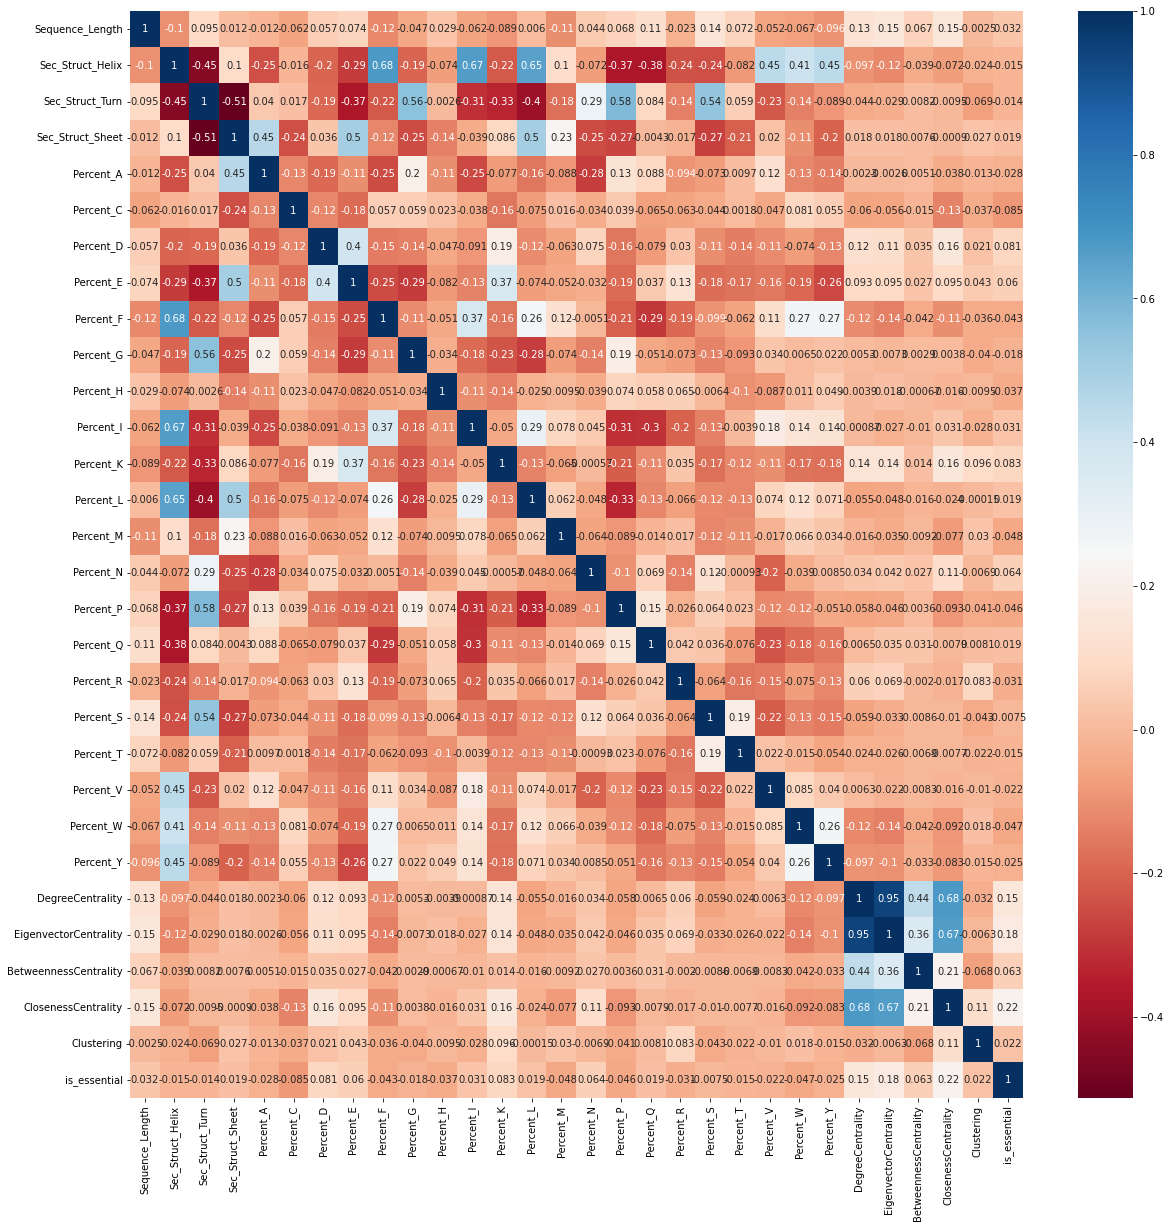

In [31]:
# Matriz de Correlação com Matplotlib Seaborn incluindo a classe de predição
plt.rcParams["figure.figsize"] = (20,20)

sns.heatmap(df.corr(), annot=True, cmap='RdBu');

In [123]:
# Função para validação cruzada sem o uso de balanceamento na amostra de validação

def validacao_cruzada(model, X, y, sampling = False, method_sampling = None):
    kfold = KFold(n_splits = 5, shuffle=True)
    
    acuracias_split = []
    
    for idx, (idx_treino, idx_validacao) in enumerate(kfold.split(X)):
        X_split_treino = X.iloc[idx_treino, :]
        y_split_treino = y.iloc[idx_treino, :]
        
        
        if sampling: 
            # Método de Sampling
            sm = method_sampling
            X_split_treino, y_split_treino = sm.fit_resample(X_split_treino, y_split_treino)
            
        model.fit(X_split_treino, y_split_treino.values.ravel())  
        
        X_split_validacao = X.iloc[idx_validacao, :]
        y_split_validacao = y.iloc[idx_validacao, :]
        
        
        pred_validacoes = model.predict(X_split_validacao)
        
        acuracia_split = accuracy_score(y_split_validacao, pred_validacoes)
        
        acuracias_split.append(acuracia_split)
        
        print(f'Acurácia do split {idx}: {acuracia_split}')
        
        mean = np.mean(acuracias_split)
        
    return print(f'Média de Acurácia na validação cruzada: {mean}')

## Pré-processamento de Dados

In [82]:
# Separação em conjuntos de treino e teste
X = df.drop(['Protein_key','is_essential', 'Locus', 'Sequence'], axis=1)
#X = df_select
y = df[['is_essential']]
test_size = 0.3
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=seed,
                                                    shuffle=True, 
                                                    stratify=y)

In [40]:
## Undersampling

undersample = RandomUnderSampler(random_state=seed)
#undersample = NearMiss()

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

y_train_under.value_counts()

0    1168
1    1168
Name: is_essential, dtype: int64

In [41]:
## Oversampling

oversample = SMOTE(random_state=seed)
#oversample = RandomOverSampler(random_state=seed)

X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

y_train_over.value_counts()

1    20189
0    20189
Name: is_essential, dtype: int64

In [42]:
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_train = scaler.fit_transform(X_train_over)
print(scaled_train)

[[7.15407433e-03 6.65432099e-01 2.21517119e-01 ... 5.16650820e-07
  5.58554743e-01 3.05555556e-01]
 [2.65224219e-02 3.66403370e-01 3.71352473e-01 ... 6.74765814e-08
  5.79671755e-01 2.00000000e-01]
 [5.06019892e-03 4.05437352e-01 2.75211008e-01 ... 3.22921319e-05
  5.34734752e-01 2.44444444e-01]
 ...
 [1.40464142e-02 5.54594437e-01 2.49570620e-01 ... 1.00331733e-02
  8.12974531e-01 2.48065841e-01]
 [4.01326121e-03 4.00143615e-01 3.13552409e-01 ... 1.28056390e-03
  7.25276367e-01 3.96057152e-01]
 [1.20834060e-02 5.13230821e-01 2.49932988e-01 ... 1.55226959e-02
  7.60517284e-01 2.37092879e-01]]


In [43]:
n_features = scaled_train.shape[1]
n_features

29

## Algoritmo XGBoost

In [117]:
xgbc = XGBClassifier(random_state=7)

# Training the XGB classifier
xgbc.fit(X_train_under, y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=7,
              reg_alpha=0, reg_lambda=1, ...)

In [124]:
# Validação cruzada 
validacao_cruzada(xgbc, X, y, True, undersample)

Acurácia do split 0: 0.7301327216123218
Acurácia do split 1: 0.7317273025237627
Acurácia do split 2: 0.7392658144870534
Acurácia do split 3: 0.7318911832186168
Acurácia do split 4: 0.7425434283841363
Média de Acurácia na validação cruzada: 0.7351120900451782


In [46]:
y_pred = xgbc.predict(X_test)

In [47]:
# Scikit-learn
print(confusion_matrix(y_test, y_pred))

[[6157 2497]
 [ 104  396]]


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.83      8654
           1       0.14      0.79      0.23       500

    accuracy                           0.72      9154
   macro avg       0.56      0.75      0.53      9154
weighted avg       0.94      0.72      0.79      9154



### Algoritmo Random Forest

In [125]:
rfc = RandomForestClassifier().fit(X_train_under, y_train_under)

In [126]:
# Validação cruzada 
validacao_cruzada(rfc, X, y, True, undersample)

Acurácia do split 0: 0.7406193675241685
Acurácia do split 1: 0.7394296951819076
Acurácia do split 2: 0.7366437233693871
Acurácia do split 3: 0.725335955424451
Acurácia do split 4: 0.7297607341855129
Média de Acurácia na validação cruzada: 0.7343578951370854


In [106]:
y_pred = rfc.predict(X_test)

In [107]:
# Scikit-learn
print(confusion_matrix(y_test, y_pred))

[[6116 2538]
 [  26  474]]


In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83      8654
           1       0.16      0.95      0.27       500

    accuracy                           0.72      9154
   macro avg       0.58      0.83      0.55      9154
weighted avg       0.95      0.72      0.80      9154

